In [1]:
import librosa
import librosa.display
import os
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

/usr/local/lib/python3.6/dist-packages/numba/errors.py:137: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:
#currdir= os.getcwd()
rootdir = '/home/taejoon/PhysioNetChallenge'
input_directory = os.path.join(rootdir, 'Training_WFDB')
# output_directory = os.path.join(rootdir, 'Mel_data')
date = datetime.today().strftime("%Y%m%d")
#save_directory = os.path.join(currdir, '')

if not os.path.isdir(input_directory):
        os.mkdir(input_directory)



In [3]:
# Find files
input_files = []
for f in os.listdir(input_directory):
    if os.path.isfile(os.path.join(input_directory, f)) and not f.lower().startswith('.') and f.lower().endswith('mat'):
        input_files.append(f)

In [4]:
input_files

['A3066.mat',
 'A4872.mat',
 'A2971.mat',
 'A4463.mat',
 'A1499.mat',
 'A4135.mat',
 'A0099.mat',
 'A5945.mat',
 'A0101.mat',
 'A6165.mat',
 'A6623.mat',
 'A1510.mat',
 'A5206.mat',
 'A6861.mat',
 'A1695.mat',
 'A4785.mat',
 'A5838.mat',
 'A5764.mat',
 'A0736.mat',
 'A4505.mat',
 'A2486.mat',
 'A4292.mat',
 'A1249.mat',
 'A2787.mat',
 'A3112.mat',
 'A2502.mat',
 'A0561.mat',
 'A0354.mat',
 'A3610.mat',
 'A1095.mat',
 'A1237.mat',
 'A0290.mat',
 'A3675.mat',
 'A1245.mat',
 'A2951.mat',
 'A2442.mat',
 'A2273.mat',
 'A4847.mat',
 'A5914.mat',
 'A2457.mat',
 'A4652.mat',
 'A3839.mat',
 'A5344.mat',
 'A3325.mat',
 'A5149.mat',
 'A1147.mat',
 'A4396.mat',
 'A4677.mat',
 'A3641.mat',
 'A3509.mat',
 'A5180.mat',
 'A1654.mat',
 'A6139.mat',
 'A6663.mat',
 'A5743.mat',
 'A4251.mat',
 'A3508.mat',
 'A2306.mat',
 'A2458.mat',
 'A3184.mat',
 'A3193.mat',
 'A2542.mat',
 'A5859.mat',
 'A0768.mat',
 'A5758.mat',
 'A0008.mat',
 'A5539.mat',
 'A1090.mat',
 'A4053.mat',
 'A2758.mat',
 'A3473.mat',
 'A275

In [5]:
np.shape(input_files)

(6877,)

### Mel Config

In [ ]:
# 원본
# sr = 500
# fftsize = 1024
# window = 1024
# hop = 294
# melBin = 224

# Square 모양 되도록 수정한 버전: 



def Mel(data, sr, fftsize, hop, window, melBin):
    # STFT
#     S = librosa.core.stft(data, n_fft=fftsize, hop_length=hop, win_length = window)
    S = librosa.core.stft(data, n_fft=fftsize, hop_length=hop, win_length = window)
    X = np.abs(S)
    
    X = X.astype(np.float32)
    # Mel basis
#     mel_basis = librosa.filters.mel(sr, n_fft = fftsize, n_mels = melBin)
#     # mal basis are multiplied to the STFT
#     mel_S = np.dot(mel_basis, X)
    
#     # log amplitude compression
#     mel_S = np.log10(1+10*mel_S)
#     mel_S = mel_S.astype(np.float32)
    
    return X
#     return mel_S

In [ ]:


def Mel(data, sr, fftsize, hop, window, melBin):
    # STFT
    S = librosa.core.stft(data, n_fft=fftsize, hop_length=hop, win_length = window)
    X = np.abs(S)
    # Mel basis
    mel_basis = librosa.filters.mel(sr, n_fft = fftsize, n_mels = melBin)
    # mal basis are multiplied to the STFT
    mel_S = np.dot(mel_basis, X)
    
    # log amplitude compression
    mel_S = np.log10(1+10*mel_S)
    mel_S = mel_S.astype(np.float32)
    
    
    return mel_S

aaa = Mel(sample_data, sr, fftsize, hop, window, melBin)
# plt.imshow(aaa)

librosa.display.specshow(aaa, sr=sr, hop_length=hop, 
                         x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB');

In [6]:

def Spectrogram(data, sr, fftsize, hop):
    # STFT
    S_test = librosa.stft(data, n_fft = fftsize, hop_length=hop)
    D = np.abs(S_test)
    DB = librosa.amplitude_to_db(D, ref=np.max)
    return DB


In [ ]:
# # Fiddling with parameters to make the output image have a certain length


# #data_test = np.zeros((12, 1500))
# sample_file = loadmat(os.path.join(input_directory, input_files[0]))
# sample_file = np.asarray(sample_file['val'], dtype=np.float64)
# sample_data = sample_file[0,:1500]
# # sample_data.shape

# S_test = librosa.stft(sample_data, n_fft = fftsize, hop_length=hop)
# D = abs(S_test)
# print(D.shape)
# librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='linear');
# plt.colorbar();
# # mel_basis = librosa.filters.mel(sr, n_fft = fftsize, n_mels = melBin)
# # print(mel_basis.shape)
# # mel_S = np.dot(mel_basis, X_test)
# # mel_S.shape
# # plt.imshow(mel_S)
# # mel_S.shape

# # mel_S[-1,-1]
# # plt.scatter(X_test)


In [ ]:
# DB = librosa.amplitude_to_db(D, ref=np.max)
# librosa.display.specshow(DB, sr=sr, hop_length=hop, 
#                          x_axis='time', y_axis='log');
# plt.colorbar(format='%+2.0f dB');
# DB.shape

In [ ]:
# comb = np.concatenate((mel_S, mel_S2), axis=0 )
# comb.shape
# plt.imshow(comb)

In [ ]:
# mel_S = np.log10(1+10*mel_S)
# mel_S = mel_S.astype(np.float32)
# plt.imshow(mel_S)

In [ ]:
plt.imshow(mel_S)

In [ ]:
aaa = np.log10(1+10*mel_S)
plt.imshow(aaa)

In [ ]:
bbb = np.log10(1+10*mel_S2)
plt.imshow(bbb)

In [7]:
def get_12ECG_features(header_data):
    tmp_hea = header_data[0].split(' ')
    ptID = tmp_hea[0]
    num_leads = int(tmp_hea[1])
    sample_Fs= int(tmp_hea[2])
    gain_lead = np.zeros(num_leads)
    for ii in range(num_leads):
        tmp_hea = header_data[ii+1].split(' ') # +1인 이유는 첫 행을 빼야하니
        gain_lead[ii] = int(tmp_hea[2].split('/')[0]) # 아마도 모든 행을 1000mV로 채울듯

    for iline in header_data:
        if iline.startswith('#Age'):
            tmp_age = iline.split(': ')[1].strip()
            age = int(tmp_age if tmp_age != 'NaN' else 57)
        elif iline.startswith('#Sex'):
            tmp_sex = iline.split(': ')[1]
            if tmp_sex.strip()=='Female':
                sex =1
            else:
                sex=0
        elif iline.startswith('#Dx'):
            label = iline.split(': ')[1].split(',')[0]
    return ptID, num_leads, sample_Fs, gain_lead, age, sex, label

In [ ]:
# input_dir = '/home/taejoon/PhysioNetChallenge/Mel_data_20200402_128'
# file = 'A0001.npy'
# a = np.load(input_dir + '/' + file.replace('.mat', '.npy'))
# im = a[:128,:,3]
# plt.imshow(im)
# im.shape
# # file2 = 'A0010.npy'
# # b= np.load(input_dir + '/' + file2.replace('.mat', '.npy'))
# # plt.imshow(b[2])
# # b[2].shape

In [11]:
sr = 500
# fftsize = 254
fftsize = 510
hop = 10 #16 #int(fftsize/2)


outname = 'Spec_data_' + date + '_fftsize' + str(fftsize) + '_hop' + str(hop)
output_directory = os.path.join(rootdir, outname)
if not os.path.isdir(output_directory):
        os.mkdir(output_directory)
output_directory



for i in range(len(input_files)): # loops over subjects
    filename = os.path.join(input_directory, input_files[i])
    x = loadmat(filename)
    data = np.asarray(x['val'], dtype=np.float64)
    new_file = filename.replace('.mat', '.hea')
    input_header_file = os.path.join(new_file)
    save_name = output_directory + '/' + input_files[i].replace('.mat', '.npy') #filename.replace('.mat', '.npy')
    if not os.path.exists(os.path.dirname(save_name)):
        os.makedirs(os.path.dirname(save_name))

    with open(input_header_file,'r') as f:
        header_data=f.readlines()
    ptID, num_leads, sample_Fs, gain_lead, age, sex, label = get_12ECG_features(header_data)

    S = []
    for j in range(data.shape[0]): # loops over 12 leads
        tmp_lead = data[j]
        S1 = Spectrogram(tmp_lead, sr, fftsize, hop)
#         S1 = Mel(tmp_lead, sr, fftsize, hop, window, melBin)
#         mel_S1 = Mel(tmp_lead, sr, fftsize, hop, window1, melBin)
#         mel_S2 = Mel(tmp_lead, sr, fftsize, hop, window2, melBin)#comb = np.concatenate((mel_S, mel_S2), axis=0 )
#         S1 = np.concatenate((mel_S1, mel_S2), axis=0 )
        S1 = list(S1)
        S.append(S1)
    S = np.swapaxes(S, 0, 2)
    print(new_file, S.shape, save_name)
    assert len(S) > (fftsize/2)+1 #256
    np.save(save_name, S)

/home/taejoon/PhysioNetChallenge/Training_WFDB/A3066.hea (2520, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3066.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4872.hea (534, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4872.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2971.hea (801, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2971.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4463.hea (559, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4463.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1499.hea (851, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1499.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4135.hea (2890, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4135.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0099.hea (1001, 256, 12) /home/taejoon/Physi

/home/taejoon/PhysioNetChallenge/Training_WFDB/A4251.hea (801, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4251.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3508.hea (551, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3508.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2306.hea (1495, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2306.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2458.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2458.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3184.hea (551, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3184.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3193.hea (1451, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3193.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2542.hea (1001, 256, 12) /home/taejoon/Physi

/home/taejoon/PhysioNetChallenge/Training_WFDB/A2485.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2485.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4693.hea (658, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4693.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6679.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6679.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4931.hea (651, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4931.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5397.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5397.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2061.hea (701, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2061.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3496.hea (731, 256, 12) /home/taejoon/PhysioNe

/home/taejoon/PhysioNetChallenge/Training_WFDB/A3799.hea (529, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3799.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0946.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0946.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3908.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3908.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1688.hea (1101, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1688.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3707.hea (821, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3707.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6787.hea (531, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6787.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2888.hea (751, 256, 12) /home/taejoon/PhysioN

/home/taejoon/PhysioNetChallenge/Training_WFDB/A0083.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0083.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3373.hea (586, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3373.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2643.hea (701, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2643.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3504.hea (608, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3504.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3156.hea (560, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3156.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4017.hea (650, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4017.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5410.hea (534, 256, 12) /home/taejoon/PhysioNe

/home/taejoon/PhysioNetChallenge/Training_WFDB/A0980.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0980.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2474.hea (2740, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2474.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2248.hea (526, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2248.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0269.hea (782, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0269.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4754.hea (651, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4754.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3887.hea (589, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3887.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3857.hea (501, 256, 12) /home/taejoon/PhysioN

/home/taejoon/PhysioNetChallenge/Training_WFDB/A4492.hea (1551, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4492.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1367.hea (751, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1367.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6761.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6761.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2465.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2465.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1947.hea (648, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1947.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5580.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5580.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3787.hea (751, 256, 12) /home/taejoon/PhysioN

/home/taejoon/PhysioNetChallenge/Training_WFDB/A6055.hea (758, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6055.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6634.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6634.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0372.hea (651, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0372.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0436.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0436.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3963.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3963.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3090.hea (791, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3090.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4816.hea (701, 256, 12) /home/taejoon/PhysioNe

/home/taejoon/PhysioNetChallenge/Training_WFDB/A4459.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4459.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0307.hea (801, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0307.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2060.hea (651, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2060.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6036.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6036.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6326.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6326.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6353.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6353.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5544.hea (851, 256, 12) /home/taejoon/PhysioNe

/home/taejoon/PhysioNetChallenge/Training_WFDB/A6379.hea (654, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6379.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5203.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5203.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6800.hea (651, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6800.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5450.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5450.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4968.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4968.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3758.hea (1993, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3758.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0799.hea (1001, 256, 12) /home/taejoon/Physio

/home/taejoon/PhysioNetChallenge/Training_WFDB/A5863.hea (2158, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5863.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3687.hea (721, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3687.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3289.hea (905, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3289.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5314.hea (602, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5314.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0788.hea (569, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0788.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4587.hea (951, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4587.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5066.hea (2035, 256, 12) /home/taejoon/Physio

/home/taejoon/PhysioNetChallenge/Training_WFDB/A0234.hea (615, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0234.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6094.hea (729, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6094.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5135.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5135.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1658.hea (1051, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1658.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3924.hea (601, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3924.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0272.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0272.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4564.hea (501, 256, 12) /home/taejoon/PhysioN

/home/taejoon/PhysioNetChallenge/Training_WFDB/A5684.hea (1201, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5684.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1384.hea (533, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1384.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0187.hea (520, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0187.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4010.hea (868, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4010.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5778.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5778.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6303.hea (705, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6303.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6546.hea (501, 256, 12) /home/taejoon/PhysioN

/home/taejoon/PhysioNetChallenge/Training_WFDB/A6250.hea (1751, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6250.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3832.hea (951, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3832.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5969.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5969.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1373.hea (1301, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1373.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6436.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6436.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5172.hea (601, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5172.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6552.hea (851, 256, 12) /home/taejoon/Physio

/home/taejoon/PhysioNetChallenge/Training_WFDB/A1533.hea (751, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1533.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6125.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6125.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0395.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0395.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6098.hea (701, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6098.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6736.hea (1224, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6736.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4525.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4525.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2812.hea (1051, 256, 12) /home/taejoon/Physio

/home/taejoon/PhysioNetChallenge/Training_WFDB/A6612.hea (1151, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6612.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1232.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1232.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0225.hea (601, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0225.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5782.hea (767, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5782.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4012.hea (801, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4012.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0438.hea (651, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0438.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5138.hea (1572, 256, 12) /home/taejoon/Physio

/home/taejoon/PhysioNetChallenge/Training_WFDB/A2420.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2420.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3481.hea (600, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3481.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5651.hea (651, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5651.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3532.hea (547, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3532.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3700.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3700.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2443.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2443.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4903.hea (1501, 256, 12) /home/taejoon/PhysioN

/home/taejoon/PhysioNetChallenge/Training_WFDB/A4826.hea (528, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4826.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0508.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0508.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4388.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4388.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5458.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5458.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0661.hea (2947, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0661.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5185.hea (751, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5185.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2645.hea (1001, 256, 12) /home/taejoon/Physio

/home/taejoon/PhysioNetChallenge/Training_WFDB/A5154.hea (582, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5154.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5924.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5924.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5388.hea (551, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5388.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4006.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4006.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3337.hea (769, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3337.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1311.hea (538, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1311.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0591.hea (1001, 256, 12) /home/taejoon/PhysioN

/home/taejoon/PhysioNetChallenge/Training_WFDB/A5718.hea (801, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5718.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5187.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5187.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3286.hea (1685, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3286.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2330.hea (601, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2330.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4615.hea (1251, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4615.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6380.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6380.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4124.hea (1201, 256, 12) /home/taejoon/Physi

/home/taejoon/PhysioNetChallenge/Training_WFDB/A1588.hea (901, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1588.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5268.hea (801, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5268.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0570.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0570.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5950.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5950.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5554.hea (1151, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5554.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0198.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0198.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5479.hea (625, 256, 12) /home/taejoon/PhysioN

/home/taejoon/PhysioNetChallenge/Training_WFDB/A3024.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3024.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1475.hea (746, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1475.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1104.hea (562, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1104.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0409.hea (951, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0409.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6732.hea (1052, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6732.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2073.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2073.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4687.hea (501, 256, 12) /home/taejoon/PhysioN

/home/taejoon/PhysioNetChallenge/Training_WFDB/A6205.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6205.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2649.hea (713, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2649.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6344.hea (551, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6344.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2813.hea (1001, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2813.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0868.hea (851, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0868.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3149.hea (651, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3149.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6706.hea (501, 256, 12) /home/taejoon/PhysioN

/home/taejoon/PhysioNetChallenge/Training_WFDB/A6784.hea (831, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6784.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4924.hea (601, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4924.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5939.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5939.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0373.hea (1586, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0373.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1186.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1186.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0672.hea (1528, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0672.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2436.hea (1251, 256, 12) /home/taejoon/Physi

/home/taejoon/PhysioNetChallenge/Training_WFDB/A5419.hea (1651, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5419.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4571.hea (1051, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4571.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1751.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1751.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5342.hea (1251, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5342.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5679.hea (785, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5679.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3075.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3075.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3167.hea (1001, 256, 12) /home/taejoon/Phys

/home/taejoon/PhysioNetChallenge/Training_WFDB/A4711.hea (747, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4711.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5699.hea (650, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5699.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2408.hea (1101, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2408.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5348.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5348.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2713.hea (701, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2713.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3901.hea (751, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3901.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5944.hea (1001, 256, 12) /home/taejoon/Physio

/home/taejoon/PhysioNetChallenge/Training_WFDB/A6109.hea (522, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6109.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4362.hea (701, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4362.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6840.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6840.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0160.hea (580, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0160.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0624.hea (1101, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0624.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4577.hea (1051, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4577.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3177.hea (501, 256, 12) /home/taejoon/Physio

/home/taejoon/PhysioNetChallenge/Training_WFDB/A0954.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0954.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3103.hea (601, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3103.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1694.hea (551, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1694.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1659.hea (601, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1659.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4199.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4199.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0526.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0526.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5658.hea (501, 256, 12) /home/taejoon/PhysioNe

/home/taejoon/PhysioNetChallenge/Training_WFDB/A6454.hea (601, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6454.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6582.hea (901, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6582.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3331.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3331.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1890.hea (1491, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1890.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3540.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3540.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2534.hea (592, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2534.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0002.hea (501, 256, 12) /home/taejoon/PhysioN

/home/taejoon/PhysioNetChallenge/Training_WFDB/A5499.hea (1101, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5499.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1972.hea (719, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1972.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3271.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3271.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5364.hea (540, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5364.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0686.hea (743, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0686.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6128.hea (2593, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6128.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2164.hea (501, 256, 12) /home/taejoon/Physio

/home/taejoon/PhysioNetChallenge/Training_WFDB/A5976.hea (1051, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5976.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2480.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2480.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2044.hea (1501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2044.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1965.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1965.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1247.hea (1201, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1247.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2216.hea (1706, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2216.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1102.hea (501, 256, 12) /home/taejoon/Phys

/home/taejoon/PhysioNetChallenge/Training_WFDB/A3956.hea (645, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3956.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6428.hea (551, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6428.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5406.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5406.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4258.hea (1001, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4258.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3673.hea (601, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3673.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5763.hea (901, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5763.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1368.hea (611, 256, 12) /home/taejoon/PhysioN

/home/taejoon/PhysioNetChallenge/Training_WFDB/A1872.hea (451, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1872.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2214.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2214.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3231.hea (739, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3231.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6450.hea (951, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6450.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4436.hea (816, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4436.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0894.hea (601, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0894.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0327.hea (501, 256, 12) /home/taejoon/PhysioNe

/home/taejoon/PhysioNetChallenge/Training_WFDB/A5871.hea (632, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5871.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2603.hea (1628, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2603.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1564.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1564.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6259.hea (726, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6259.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3576.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3576.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3795.hea (751, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3795.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0445.hea (2506, 256, 12) /home/taejoon/Physio

/home/taejoon/PhysioNetChallenge/Training_WFDB/A5380.hea (653, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5380.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2140.hea (601, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2140.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4915.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4915.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0453.hea (801, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0453.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4619.hea (2001, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4619.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5537.hea (601, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5537.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2274.hea (906, 256, 12) /home/taejoon/PhysioN

/home/taejoon/PhysioNetChallenge/Training_WFDB/A0138.hea (604, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0138.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6755.hea (701, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6755.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3450.hea (557, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3450.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0916.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0916.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0342.hea (551, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0342.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0536.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0536.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1412.hea (799, 256, 12) /home/taejoon/PhysioNe

/home/taejoon/PhysioNetChallenge/Training_WFDB/A6765.hea (1718, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6765.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4781.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4781.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3012.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3012.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5850.hea (964, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5850.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1174.hea (537, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1174.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4189.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4189.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0425.hea (501, 256, 12) /home/taejoon/PhysioN

/home/taejoon/PhysioNetChallenge/Training_WFDB/A6172.hea (551, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6172.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5609.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5609.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1326.hea (578, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1326.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5056.hea (551, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5056.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1634.hea (542, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1634.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3849.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3849.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2360.hea (651, 256, 12) /home/taejoon/PhysioNe

/home/taejoon/PhysioNetChallenge/Training_WFDB/A6667.hea (783, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6667.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4631.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4631.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2346.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2346.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4002.hea (1651, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4002.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1112.hea (531, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1112.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1770.hea (1576, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1770.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0828.hea (641, 256, 12) /home/taejoon/Physio

/home/taejoon/PhysioNetChallenge/Training_WFDB/A0821.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0821.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6613.hea (601, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6613.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4930.hea (851, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4930.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2964.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2964.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5153.hea (667, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5153.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2029.hea (619, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2029.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0953.hea (501, 256, 12) /home/taejoon/PhysioNe

/home/taejoon/PhysioNetChallenge/Training_WFDB/A5523.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5523.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2411.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2411.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6704.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6704.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6437.hea (651, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6437.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2440.hea (1551, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2440.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5568.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5568.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2137.hea (1201, 256, 12) /home/taejoon/Physio

/home/taejoon/PhysioNetChallenge/Training_WFDB/A3379.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3379.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4661.hea (1029, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4661.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6794.hea (651, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6794.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0996.hea (664, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0996.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5293.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5293.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0974.hea (1601, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0974.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0598.hea (501, 256, 12) /home/taejoon/Physio

/home/taejoon/PhysioNetChallenge/Training_WFDB/A0847.hea (701, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0847.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6215.hea (701, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6215.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5683.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5683.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0183.hea (2136, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0183.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5935.hea (701, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5935.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1017.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1017.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4799.hea (501, 256, 12) /home/taejoon/PhysioN

/home/taejoon/PhysioNetChallenge/Training_WFDB/A5352.hea (751, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5352.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4285.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4285.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1953.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1953.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2942.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2942.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0567.hea (601, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0567.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0255.hea (1728, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0255.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5937.hea (551, 256, 12) /home/taejoon/PhysioN

/home/taejoon/PhysioNetChallenge/Training_WFDB/A3693.hea (701, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3693.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5670.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5670.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1796.hea (1101, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1796.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1460.hea (809, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1460.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5173.hea (551, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5173.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6596.hea (951, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6596.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6073.hea (501, 256, 12) /home/taejoon/PhysioN

/home/taejoon/PhysioNetChallenge/Training_WFDB/A1924.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1924.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2071.hea (534, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2071.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2300.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2300.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1406.hea (1601, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1406.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4256.hea (701, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4256.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2849.hea (1551, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2849.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0216.hea (530, 256, 12) /home/taejoon/Physio

/home/taejoon/PhysioNetChallenge/Training_WFDB/A6686.hea (590, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6686.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0807.hea (901, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0807.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6518.hea (601, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6518.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6498.hea (839, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6498.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1299.hea (851, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1299.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5981.hea (651, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5981.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0681.hea (1001, 256, 12) /home/taejoon/PhysioN

/home/taejoon/PhysioNetChallenge/Training_WFDB/A0244.hea (551, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0244.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1720.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1720.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1576.hea (968, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1576.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6515.hea (1051, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6515.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6744.hea (697, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6744.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4242.hea (751, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4242.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5623.hea (501, 256, 12) /home/taejoon/PhysioN

/home/taejoon/PhysioNetChallenge/Training_WFDB/A3122.hea (1501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3122.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6455.hea (590, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6455.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3768.hea (1001, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3768.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5788.hea (853, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5788.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5420.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5420.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4110.hea (751, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4110.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0140.hea (633, 256, 12) /home/taejoon/Physio

/home/taejoon/PhysioNetChallenge/Training_WFDB/A0151.hea (918, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0151.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0392.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0392.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0825.hea (801, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0825.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2798.hea (3001, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2798.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1067.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1067.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6393.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6393.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6618.hea (618, 256, 12) /home/taejoon/PhysioN

/home/taejoon/PhysioNetChallenge/Training_WFDB/A4448.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4448.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2135.hea (951, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2135.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3452.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3452.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6079.hea (539, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6079.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2973.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2973.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2674.hea (1851, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2674.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4035.hea (701, 256, 12) /home/taejoon/PhysioN

/home/taejoon/PhysioNetChallenge/Training_WFDB/A0724.hea (1672, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0724.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0689.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0689.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6121.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6121.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3086.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3086.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0141.hea (1347, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0141.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2207.hea (542, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2207.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0384.hea (501, 256, 12) /home/taejoon/Physio

/home/taejoon/PhysioNetChallenge/Training_WFDB/A3162.hea (700, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3162.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2444.hea (751, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2444.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6577.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6577.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0841.hea (1001, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0841.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1458.hea (951, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1458.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3860.hea (708, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3860.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3335.hea (1030, 256, 12) /home/taejoon/Physio

/home/taejoon/PhysioNetChallenge/Training_WFDB/A5394.hea (721, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5394.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5639.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5639.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0574.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0574.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5246.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5246.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1256.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1256.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4331.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4331.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5454.hea (501, 256, 12) /home/taejoon/PhysioNe

/home/taejoon/PhysioNetChallenge/Training_WFDB/A4139.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4139.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2571.hea (1151, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2571.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0439.hea (1232, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0439.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5896.hea (626, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5896.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3262.hea (1385, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3262.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1258.hea (1924, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1258.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3503.hea (651, 256, 12) /home/taejoon/Phys

/home/taejoon/PhysioNetChallenge/Training_WFDB/A1781.hea (1201, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1781.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4849.hea (569, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4849.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0882.hea (701, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0882.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0241.hea (2444, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0241.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4366.hea (1634, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4366.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0879.hea (601, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0879.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6790.hea (801, 256, 12) /home/taejoon/Physi

/home/taejoon/PhysioNetChallenge/Training_WFDB/A0666.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0666.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1008.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1008.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2772.hea (740, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2772.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6791.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6791.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2275.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2275.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6651.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6651.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6286.hea (851, 256, 12) /home/taejoon/PhysioNe

/home/taejoon/PhysioNetChallenge/Training_WFDB/A5256.hea (599, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5256.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2271.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2271.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0772.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0772.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2702.hea (601, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2702.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6470.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6470.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3448.hea (687, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3448.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5313.hea (612, 256, 12) /home/taejoon/PhysioNe

/home/taejoon/PhysioNetChallenge/Training_WFDB/A2032.hea (806, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2032.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4419.hea (951, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4419.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4658.hea (562, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4658.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3725.hea (651, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3725.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5300.hea (601, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5300.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3776.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3776.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4015.hea (1001, 256, 12) /home/taejoon/PhysioN

/home/taejoon/PhysioNetChallenge/Training_WFDB/A2678.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2678.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6682.hea (1001, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6682.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4007.hea (551, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4007.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5426.hea (1851, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5426.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3847.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3847.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5909.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5909.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2496.hea (651, 256, 12) /home/taejoon/Physio

/home/taejoon/PhysioNetChallenge/Training_WFDB/A5082.hea (840, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5082.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3898.hea (1951, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3898.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4483.hea (839, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4483.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5428.hea (701, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5428.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6296.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6296.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2894.hea (628, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2894.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6491.hea (901, 256, 12) /home/taejoon/PhysioN

/home/taejoon/PhysioNetChallenge/Training_WFDB/A4019.hea (751, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4019.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1560.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1560.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0794.hea (627, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0794.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3922.hea (751, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3922.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2069.hea (801, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2069.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3190.hea (579, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3190.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5541.hea (951, 256, 12) /home/taejoon/PhysioNe

/home/taejoon/PhysioNetChallenge/Training_WFDB/A0265.hea (551, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0265.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1998.hea (801, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1998.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2338.hea (593, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2338.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0815.hea (2251, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0815.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2530.hea (651, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2530.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4964.hea (1551, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4964.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1029.hea (501, 256, 12) /home/taejoon/Physio

/home/taejoon/PhysioNetChallenge/Training_WFDB/A0577.hea (806, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0577.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6313.hea (1351, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6313.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3605.hea (3001, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3605.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3506.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3506.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4986.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4986.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3191.hea (521, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3191.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3399.hea (501, 256, 12) /home/taejoon/Physio

/home/taejoon/PhysioNetChallenge/Training_WFDB/A2625.hea (751, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2625.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1512.hea (811, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1512.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1883.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1883.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0096.hea (1761, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0096.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0386.hea (951, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0386.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1575.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1575.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6298.hea (1201, 256, 12) /home/taejoon/Physio

/home/taejoon/PhysioNetChallenge/Training_WFDB/A1201.hea (551, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1201.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3710.hea (607, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3710.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5995.hea (851, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5995.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0808.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0808.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5251.hea (1099, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5251.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1451.hea (582, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1451.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0450.hea (605, 256, 12) /home/taejoon/PhysioN

/home/taejoon/PhysioNetChallenge/Training_WFDB/A4429.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4429.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5076.hea (745, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5076.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4527.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4527.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2861.hea (811, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2861.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3014.hea (601, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3014.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3672.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3672.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1096.hea (651, 256, 12) /home/taejoon/PhysioNe

/home/taejoon/PhysioNetChallenge/Training_WFDB/A6836.hea (1051, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6836.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4938.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4938.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0479.hea (543, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0479.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1678.hea (551, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1678.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5077.hea (651, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5077.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1646.hea (696, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1646.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5495.hea (501, 256, 12) /home/taejoon/PhysioN

/home/taejoon/PhysioNetChallenge/Training_WFDB/A5390.hea (597, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5390.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3716.hea (1351, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3716.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1507.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1507.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3870.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3870.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1968.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1968.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5597.hea (550, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5597.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0293.hea (588, 256, 12) /home/taejoon/PhysioN

/home/taejoon/PhysioNetChallenge/Training_WFDB/A0184.hea (1151, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0184.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3754.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3754.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3500.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3500.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0401.hea (601, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0401.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0137.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0137.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3661.hea (734, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3661.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1798.hea (1618, 256, 12) /home/taejoon/Physio

/home/taejoon/PhysioNetChallenge/Training_WFDB/A5042.hea (2063, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5042.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5279.hea (1151, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5279.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3529.hea (651, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3529.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0314.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0314.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2577.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2577.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0720.hea (781, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0720.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6005.hea (651, 256, 12) /home/taejoon/Physio

/home/taejoon/PhysioNetChallenge/Training_WFDB/A4911.hea (1251, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4911.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2310.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2310.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5408.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5408.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6796.hea (525, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6796.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4759.hea (533, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4759.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1163.hea (1001, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1163.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1476.hea (501, 256, 12) /home/taejoon/Physio

/home/taejoon/PhysioNetChallenge/Training_WFDB/A1995.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1995.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1668.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1668.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2400.hea (588, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2400.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1504.hea (551, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1504.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2122.hea (610, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2122.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2638.hea (551, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2638.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6701.hea (501, 256, 12) /home/taejoon/PhysioNe

/home/taejoon/PhysioNetChallenge/Training_WFDB/A3969.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3969.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5987.hea (1051, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5987.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0448.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0448.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5382.hea (851, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5382.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5656.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5656.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1161.hea (801, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1161.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4515.hea (627, 256, 12) /home/taejoon/PhysioN

/home/taejoon/PhysioNetChallenge/Training_WFDB/A3797.hea (712, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3797.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0233.hea (1201, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0233.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5605.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5605.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2371.hea (651, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2371.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0697.hea (551, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0697.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1492.hea (619, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1492.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5353.hea (881, 256, 12) /home/taejoon/PhysioN

/home/taejoon/PhysioNetChallenge/Training_WFDB/A0586.hea (597, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0586.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6258.hea (701, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6258.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1461.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1461.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3243.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3243.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0006.hea (701, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0006.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2552.hea (951, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2552.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5868.hea (577, 256, 12) /home/taejoon/PhysioNe

/home/taejoon/PhysioNetChallenge/Training_WFDB/A3151.hea (851, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3151.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1592.hea (1350, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1592.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5142.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5142.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5452.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5452.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5472.hea (570, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5472.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4753.hea (751, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4753.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6168.hea (611, 256, 12) /home/taejoon/PhysioN

/home/taejoon/PhysioNetChallenge/Training_WFDB/A5915.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5915.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4994.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4994.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1877.hea (601, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1877.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5522.hea (1001, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5522.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5798.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5798.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4288.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4288.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2803.hea (951, 256, 12) /home/taejoon/PhysioN

/home/taejoon/PhysioNetChallenge/Training_WFDB/A6673.hea (801, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6673.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6043.hea (651, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6043.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2887.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2887.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1571.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1571.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3429.hea (1351, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3429.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5370.hea (801, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5370.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3628.hea (751, 256, 12) /home/taejoon/PhysioN

/home/taejoon/PhysioNetChallenge/Training_WFDB/A5427.hea (1251, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5427.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5007.hea (601, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5007.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1645.hea (551, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1645.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4342.hea (2675, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4342.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4627.hea (693, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4627.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5403.hea (559, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5403.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5668.hea (501, 256, 12) /home/taejoon/Physio

/home/taejoon/PhysioNetChallenge/Training_WFDB/A2846.hea (851, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2846.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1302.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1302.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3003.hea (677, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3003.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5044.hea (951, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5044.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2657.hea (611, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2657.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3457.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3457.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2298.hea (851, 256, 12) /home/taejoon/PhysioNe

/home/taejoon/PhysioNetChallenge/Training_WFDB/A0429.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0429.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5038.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5038.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3736.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3736.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3582.hea (801, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3582.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3804.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3804.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1141.hea (601, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1141.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0707.hea (1201, 256, 12) /home/taejoon/PhysioN

/home/taejoon/PhysioNetChallenge/Training_WFDB/A6115.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6115.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2844.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2844.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5913.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5913.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6218.hea (1434, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6218.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4132.hea (1301, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4132.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1204.hea (1101, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1204.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4186.hea (501, 256, 12) /home/taejoon/Physi

/home/taejoon/PhysioNetChallenge/Training_WFDB/A4862.hea (1451, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4862.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3522.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3522.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6444.hea (651, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6444.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6310.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6310.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0237.hea (773, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0237.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3346.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3346.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6471.hea (1001, 256, 12) /home/taejoon/Physio

/home/taejoon/PhysioNetChallenge/Training_WFDB/A2446.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2446.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6340.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6340.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4403.hea (1051, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4403.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3029.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3029.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5266.hea (1567, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5266.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5183.hea (1851, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5183.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3775.hea (565, 256, 12) /home/taejoon/Physi

/home/taejoon/PhysioNetChallenge/Training_WFDB/A1489.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1489.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2425.hea (2051, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2425.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0915.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0915.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5531.hea (851, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5531.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5851.hea (600, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5851.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6617.hea (551, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6617.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4907.hea (785, 256, 12) /home/taejoon/PhysioN

/home/taejoon/PhysioNetChallenge/Training_WFDB/A1166.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1166.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4029.hea (551, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4029.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3526.hea (529, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3526.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0324.hea (1051, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0324.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0091.hea (751, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0091.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4375.hea (830, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4375.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0682.hea (501, 256, 12) /home/taejoon/PhysioN

/home/taejoon/PhysioNetChallenge/Training_WFDB/A2616.hea (651, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2616.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0933.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0933.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0709.hea (801, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0709.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0322.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0322.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1503.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1503.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6570.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6570.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1032.hea (501, 256, 12) /home/taejoon/PhysioNe

/home/taejoon/PhysioNetChallenge/Training_WFDB/A2823.hea (751, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2823.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5159.hea (951, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5159.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6468.hea (1767, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6468.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4475.hea (971, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4475.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1660.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1660.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1183.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1183.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3544.hea (1201, 256, 12) /home/taejoon/Physio

/home/taejoon/PhysioNetChallenge/Training_WFDB/A3907.hea (551, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3907.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0886.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0886.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4442.hea (558, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4442.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3560.hea (792, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3560.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6797.hea (591, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6797.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2067.hea (654, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2067.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3360.hea (1001, 256, 12) /home/taejoon/PhysioN

/home/taejoon/PhysioNetChallenge/Training_WFDB/A6213.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6213.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2864.hea (601, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2864.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2922.hea (3001, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2922.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1470.hea (751, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1470.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6406.hea (521, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6406.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0254.hea (701, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0254.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3268.hea (2236, 256, 12) /home/taejoon/Physio

/home/taejoon/PhysioNetChallenge/Training_WFDB/A1267.hea (1976, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1267.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6632.hea (1756, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6632.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3021.hea (851, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3021.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4731.hea (651, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4731.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0534.hea (1001, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0534.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4744.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4744.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1717.hea (648, 256, 12) /home/taejoon/Physi

/home/taejoon/PhysioNetChallenge/Training_WFDB/A1155.hea (1001, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1155.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4877.hea (701, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4877.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6360.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6360.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3920.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3920.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3181.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3181.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5576.hea (1001, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5576.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0903.hea (800, 256, 12) /home/taejoon/Physio

/home/taejoon/PhysioNetChallenge/Training_WFDB/A4972.hea (1956, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4972.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1572.hea (2640, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1572.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2497.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2497.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5570.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5570.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0031.hea (1101, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0031.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0738.hea (1401, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0738.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3584.hea (501, 256, 12) /home/taejoon/Phys

/home/taejoon/PhysioNetChallenge/Training_WFDB/A3009.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3009.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3355.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3355.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2410.hea (600, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2410.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1136.hea (605, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1136.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0238.hea (701, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0238.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6187.hea (1001, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6187.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5578.hea (501, 256, 12) /home/taejoon/PhysioN

/home/taejoon/PhysioNetChallenge/Training_WFDB/A2930.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2930.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5250.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5250.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5405.hea (651, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5405.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5824.hea (1201, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5824.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2564.hea (751, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2564.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2992.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2992.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2354.hea (1634, 256, 12) /home/taejoon/Physio

/home/taejoon/PhysioNetChallenge/Training_WFDB/A4421.hea (1001, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4421.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3536.hea (2063, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3536.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2209.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2209.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2399.hea (585, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2399.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3241.hea (1001, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3241.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2326.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2326.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2761.hea (1001, 256, 12) /home/taejoon/Phys

/home/taejoon/PhysioNetChallenge/Training_WFDB/A5169.hea (1943, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5169.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5057.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5057.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0968.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0968.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5692.hea (1651, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5692.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5315.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5315.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0408.hea (519, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0408.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3202.hea (1251, 256, 12) /home/taejoon/Physi

/home/taejoon/PhysioNetChallenge/Training_WFDB/A6877.hea (1849, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6877.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5728.hea (751, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5728.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3957.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3957.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0341.hea (725, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0341.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1441.hea (757, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1441.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4666.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4666.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6350.hea (569, 256, 12) /home/taejoon/PhysioN

/home/taejoon/PhysioNetChallenge/Training_WFDB/A5740.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5740.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2792.hea (601, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2792.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4509.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4509.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1708.hea (651, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1708.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0505.hea (701, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0505.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4940.hea (601, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4940.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5738.hea (557, 256, 12) /home/taejoon/PhysioNe

/home/taejoon/PhysioNetChallenge/Training_WFDB/A5147.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5147.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4264.hea (522, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4264.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2672.hea (801, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2672.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2667.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2667.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3822.hea (1700, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3822.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0663.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0663.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4857.hea (501, 256, 12) /home/taejoon/PhysioN

/home/taejoon/PhysioNetChallenge/Training_WFDB/A4231.hea (701, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4231.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0467.hea (545, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0467.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4892.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4892.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3578.hea (1051, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3578.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1664.hea (851, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1664.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6815.hea (1951, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6815.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2182.hea (1101, 256, 12) /home/taejoon/Physi

/home/taejoon/PhysioNetChallenge/Training_WFDB/A2962.hea (601, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2962.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4596.hea (649, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4596.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5898.hea (651, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5898.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5501.hea (1151, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5501.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2862.hea (556, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2862.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0093.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0093.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0537.hea (501, 256, 12) /home/taejoon/PhysioN

/home/taejoon/PhysioNetChallenge/Training_WFDB/A0837.hea (1401, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0837.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0763.hea (551, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0763.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2845.hea (701, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2845.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4949.hea (3001, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4949.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3130.hea (551, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3130.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1072.hea (1501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1072.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2479.hea (501, 256, 12) /home/taejoon/Physi

/home/taejoon/PhysioNetChallenge/Training_WFDB/A2704.hea (605, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2704.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6827.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6827.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0413.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0413.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3914.hea (765, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3914.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2009.hea (1201, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2009.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6713.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6713.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6460.hea (581, 256, 12) /home/taejoon/PhysioN

/home/taejoon/PhysioNetChallenge/Training_WFDB/A2169.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2169.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0824.hea (951, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0824.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6595.hea (563, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6595.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5052.hea (555, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5052.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5946.hea (1051, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5946.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5182.hea (1151, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5182.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6305.hea (501, 256, 12) /home/taejoon/Physio

/home/taejoon/PhysioNetChallenge/Training_WFDB/A3676.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3676.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5006.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5006.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5247.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5247.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1048.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1048.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4333.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4333.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2523.hea (531, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2523.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2789.hea (1001, 256, 12) /home/taejoon/PhysioN

/home/taejoon/PhysioNetChallenge/Training_WFDB/A0861.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0861.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3682.hea (574, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3682.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1903.hea (777, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1903.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3517.hea (751, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3517.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0488.hea (591, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0488.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5096.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5096.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4489.hea (1563, 256, 12) /home/taejoon/PhysioN

/home/taejoon/PhysioNetChallenge/Training_WFDB/A0167.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0167.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0224.hea (801, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0224.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3061.hea (1001, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3061.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3739.hea (601, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3739.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1069.hea (567, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1069.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2675.hea (801, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2675.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5845.hea (666, 256, 12) /home/taejoon/PhysioN

/home/taejoon/PhysioNetChallenge/Training_WFDB/A4496.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4496.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2045.hea (639, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2045.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3943.hea (2683, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3943.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3890.hea (647, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3890.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4351.hea (751, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4351.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2387.hea (590, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2387.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0023.hea (501, 256, 12) /home/taejoon/PhysioN

/home/taejoon/PhysioNetChallenge/Training_WFDB/A2834.hea (3001, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2834.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2174.hea (701, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2174.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5310.hea (598, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5310.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4880.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4880.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3744.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3744.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3411.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3411.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1746.hea (501, 256, 12) /home/taejoon/PhysioN

/home/taejoon/PhysioNetChallenge/Training_WFDB/A1961.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1961.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2151.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2151.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2165.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2165.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5704.hea (851, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5704.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1012.hea (551, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1012.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2682.hea (601, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2682.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4355.hea (501, 256, 12) /home/taejoon/PhysioNe

/home/taejoon/PhysioNetChallenge/Training_WFDB/A4073.hea (1101, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4073.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3604.hea (582, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3604.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5791.hea (601, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5791.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1848.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1848.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5349.hea (736, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5349.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2003.hea (696, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2003.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2039.hea (601, 256, 12) /home/taejoon/PhysioN

/home/taejoon/PhysioNetChallenge/Training_WFDB/A3704.hea (807, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3704.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6806.hea (901, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6806.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2218.hea (2416, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2218.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5737.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5737.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3087.hea (2248, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3087.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5961.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5961.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4510.hea (551, 256, 12) /home/taejoon/Physio

/home/taejoon/PhysioNetChallenge/Training_WFDB/A2315.hea (1301, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2315.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4833.hea (601, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4833.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3213.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3213.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0079.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0079.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0236.hea (1101, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0236.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4878.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4878.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3294.hea (1601, 256, 12) /home/taejoon/Physi

/home/taejoon/PhysioNetChallenge/Training_WFDB/A4311.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4311.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0814.hea (625, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0814.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6277.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6277.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1436.hea (648, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1436.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1338.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1338.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4050.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4050.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2896.hea (541, 256, 12) /home/taejoon/PhysioNe

/home/taejoon/PhysioNetChallenge/Training_WFDB/A4081.hea (1001, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4081.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3688.hea (551, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3688.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1297.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1297.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0557.hea (1101, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0557.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5712.hea (751, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5712.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2828.hea (1238, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2828.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1153.hea (801, 256, 12) /home/taejoon/Physi

/home/taejoon/PhysioNetChallenge/Training_WFDB/A4743.hea (651, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4743.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3396.hea (620, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3396.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2740.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2740.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6862.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6862.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1797.hea (551, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1797.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2979.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2979.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6783.hea (501, 256, 12) /home/taejoon/PhysioNe

/home/taejoon/PhysioNetChallenge/Training_WFDB/A3882.hea (761, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3882.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2406.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2406.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3798.hea (751, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3798.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4393.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4393.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4846.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4846.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3063.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3063.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4270.hea (751, 256, 12) /home/taejoon/PhysioNe

/home/taejoon/PhysioNetChallenge/Training_WFDB/A1206.hea (1001, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1206.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4158.hea (651, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A4158.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1054.hea (1051, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1054.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A0538.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A0538.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1932.hea (547, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1932.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6619.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6619.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3150.hea (1051, 256, 12) /home/taejoon/Physi

/home/taejoon/PhysioNetChallenge/Training_WFDB/A6071.hea (2016, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6071.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6345.hea (501, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6345.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1093.hea (941, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1093.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5775.hea (1001, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5775.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2563.hea (651, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2563.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6825.hea (1451, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6825.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2880.hea (951, 256, 12) /home/taejoon/Physi

/home/taejoon/PhysioNetChallenge/Training_WFDB/A6802.hea (618, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6802.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2088.hea (870, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2088.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2808.hea (1118, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2808.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1497.hea (801, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1497.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6096.hea (801, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6096.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2123.hea (603, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2123.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2970.hea (501, 256, 12) /home/taejoon/PhysioN

/home/taejoon/PhysioNetChallenge/Training_WFDB/A1484.hea (1451, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1484.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A1131.hea (642, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A1131.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A5642.hea (3001, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A5642.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A6140.hea (951, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A6140.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A3175.hea (701, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A3175.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A2335.hea (2076, 256, 12) /home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10/A2335.npy
/home/taejoon/PhysioNetChallenge/Training_WFDB/A4678.hea (751, 256, 12) /home/taejoon/Physi

In [12]:
output_directory

'/home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop10'

In [13]:
S.shape

(551, 256, 12)

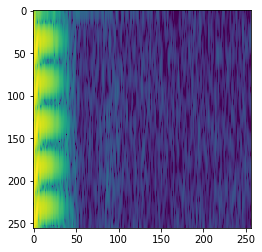

In [26]:
plt.imshow(S[:256,:,0])

In [10]:
save_name

'/home/taejoon/PhysioNetChallenge/Spec_data_20200423_fftsize510_hop16/A5277.npy'

In [ ]:
save_name = results_directory + '/' + input_files[i].replace('.mat', '.npy') #filename.replace('.mat', '.npy')
np.save(save_name, S)

In [ ]:
S.max()

In [ ]:
S.min()

In [ ]:
S.shape

In [ ]:
S